In [61]:
from copy import deepcopy

import cheetah
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import Bounds, minimize
from tqdm import tqdm

from environments import ARESEAOptimization

In [2]:
senv = ARESEAOptimization(backend="simulation", backendargs={"measure_beam": "direct"})
menv = ARESEAOptimization(backend="machine", backendargs={"measure_beam": "us"})

In [47]:
segment = deepcopy(senv.backend._segment)

## Screen Misalignment
Turn everything off. Assuming we are in the golden orbit, the position on the screen gives the screen's misalignment.

In [19]:
menv.next_initial = np.zeros(5)
menv.reset()
beam_parameters = menv.backend.compute_beam_parameters()
screen_misalignment = (beam_parameters[0], beam_parameters[1])
screen_misalignment

(-0.0009893004, 0.000195752)

In [67]:
pydoocs.dummy.dummy.segment.AREABSCR1.misalignment

(-9.159563359928731e-05, 0.00013213711123191184)

In [48]:
segment.AREABSCR1.misalignment = screen_misalignment

## Run Quadrupole Scan
This can be used to get the quadrupole misalignments. The scan of AREAMQZM1 is also used to characterise the incoming beam.

In [26]:
menv.next_initial = "stay"
menv.reset()

quadnames = ["AREAMQZM1", "AREAMQZM2", "AREAMQZM3"]
quadindices = {"AREAMQZM1": 0, "AREAMQZM2": 1, "AREAMQZM3": 3}
quadvalues = {
    "AREAMQZM1": np.linspace(-6, 6, num=9),
    "AREAMQZM2": np.linspace(-6, 6, num=3),
    "AREAMQZM3": np.linspace(-6, 6, num=3)
}

beam_parameters = {}
for quadrupole in quadnames:
    quad_beam_parameters = []
    for k1 in tqdm(quadvalues[quadrupole]):
        actuators = np.zeros(5)
        actuators[quadindices[quadrupole]] = k1
        quad_beam_parameters.append(menv.backend.compute_beam_parameters())
    beam_parameters[quadrupole] = quad_beam_parameters

100%|██████████| 3/3 [00:13<00:00,  4.53s/it]


## Find Quadrupole Misalignments
Optimise for the misalignments of the quadrupoles using the data from the scan above.

In [30]:
beam_positions = {
    quad: np.concatenate([params[0][:2], params[-1][:2]]) for quad, params in beam_parameters.items()
}
beam_positions

{'AREAMQZM1': array([-0.00098266,  0.00020065, -0.00098266,  0.00020065]),
 'AREAMQZM2': array([-0.00098266,  0.00020554, -0.00097602,  0.00020065]),
 'AREAMQZM3': array([-0.00098266,  0.00019575, -0.00097602,  0.00020065])}

In [41]:
quad_misalignments = {}
for quadname in quadnames:
    segment.AREAMQZM1.k1 = 0
    segment.AREAMQZM2.k1 = 0
    segment.AREAMQZM3.k1 = 0
    segment.AREAMCVM1.angle = 0
    segment.AREAMCHM1.angle = 0

    def optfn(misalignment):
        quad = getattr(segment, quadname)
        screen = segment.AREABSCR1

        quad.misalignment = misalignment
        incoming = cheetah.ParameterBeam.from_parameters(mu_x=0, mu_xp=0, mu_y=0, mu_yp=0)
        
        quad.k1 = quadvalues[quadname][0]
        segment(incoming)
        pos1 = (screen.read_beam.mu_x, screen.read_beam.mu_y)
        
        quad.k1 = quadvalues[quadname][0]
        segment(incoming)
        pos2 = (screen.read_beam.mu_x, screen.read_beam.mu_y)

        positions = np.concatenate([pos1, pos2])

        return np.mean((beam_positions[quadname] - positions)**2)
    
    optresult = minimize(optfn, x0=(0,0), method="Nelder-Mead")

    quad_misalignments[quadname] = optresult["x"]

quad_misalignments

{'AREAMQZM1': array([0.00150256, 0.00032703]),
 'AREAMQZM2': array([0.00210284, 0.00048627]),
 'AREAMQZM3': array([0.00375122, 0.00074585])}

In [68]:
print(pydoocs.dummy.dummy.segment.AREAMQZM1.misalignment)
print(pydoocs.dummy.dummy.segment.AREAMQZM2.misalignment)
print(pydoocs.dummy.dummy.segment.AREAMQZM3.misalignment)

(-9.273758994918802e-05, 0.0001468202966657402)
(0.00011814138500478084, 3.423127864380721e-05)
(-2.6225445181015153e-05, 0.00015054358727308143)


In [49]:
segment.AREAMQZM1.misalignment = quad_misalignments["AREAMQZM1"]
segment.AREAMQZM2.misalignment = quad_misalignments["AREAMQZM2"]
segment.AREAMQZM3.misalignment = quad_misalignments["AREAMQZM3"]

## Infer Missing Beam Parameters
Assuming the the beam is on the golden orbit and now knowing more about the misalignments, we can optimise for the remaining parameters of the incoming beam.

In [57]:
segment.AREAMQZM1.k1 = 0
segment.AREAMQZM2.k1 = 0
segment.AREAMQZM3.k1 = 0
segment.AREAMCVM1.angle = 0
segment.AREAMCHM1.angle = 0

def optfn(parameters):
    incoming = cheetah.ParameterBeam.from_parameters(mu_x=0, mu_xp=0, mu_y=0, mu_yp=0,
        sigma_x=parameters[0], sigma_xp=parameters[1], sigma_y=parameters[2], sigma_yp=parameters[3])

    measureds = []
    for k1 in quadvalues["AREAMQZM1"]:
        segment.AREAMQZM1.k1 = k1
        segment(incoming)

        screen = segment.AREABSCR1
        measured = np.array([
            screen.read_beam.mu_x,
            screen.read_beam.mu_y,
            screen.read_beam.sigma_x,
            screen.read_beam.sigma_y,
        ])
        measureds.append(measured)
    
    measureds = np.concatenate(measureds)
    read = np.concatenate(beam_parameters["AREAMQZM1"])

    return ((measureds - read)**2).mean()

optresult = minimize(optfn, x0=np.zeros(4), method="Nelder-Mead")

incoming = {
    "mu_x": 0, "mu_xp": 0, "mu_y": 0, "mu_yp": 0,
    "sigma_x": optresult["x"][0], "sigma_xp": optresult["x"][1],
    "sigma_y": optresult["x"][2], "sigma_yp": optresult["x"][3]
}

incoming

{'mu_x': 0,
 'mu_xp': 0,
 'mu_y': 0,
 'mu_yp': 0,
 'sigma_x': 8.90640541620087e-05,
 'sigma_xp': 0.00023964769285521467,
 'sigma_y': 7.738284496008421e-05,
 'sigma_yp': 0.00024535872353590094}

## Optimise in Simulation

In [59]:
desired = np.zeros(4)

In [60]:
senv.next_initial = [10, -10, 10, 0, 0]
senv.backend.next_incoming = incoming
senv.backend.next_misalignments = [
    quad_misalignments["AREAMQZM1"][0], quad_misalignments["AREAMQZM1"][1],
    quad_misalignments["AREAMQZM2"][0], quad_misalignments["AREAMQZM2"][1],
    quad_misalignments["AREAMQZM3"][0], quad_misalignments["AREAMQZM3"][1],
    screen_misalignment[0], screen_misalignment[1]
]
senv.next_desired = desired

observation = senv.reset()

def optfn(actuators):
    observation, objective, _, _ = senv.step(actuators)
    return objective

bounds = Bounds(senv.action_space.low, senv.action_space.high)
optresult = minimize(optfn, observation[:5], method="Nelder-Mead", bounds=bounds)

optresult["x"]

array([-5.36294680e+00, -1.88199610e+01,  1.66558912e+01, -8.07210795e-04,
       -5.99995302e-03])

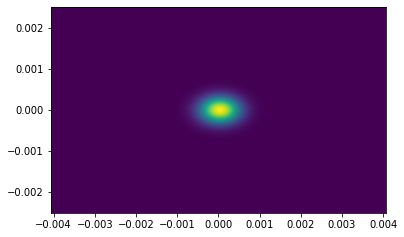

In [65]:
senv.step(optresult["x"])
plt.imshow(senv.backend.capture_clean_beam(), extent=senv.backend._segment.AREABSCR1.extent)
plt.show()

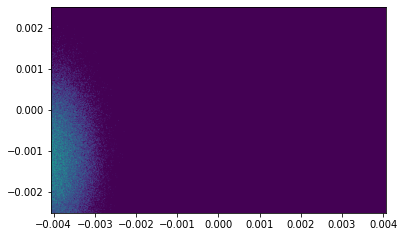

In [63]:
menv.step(optresult["x"])

plt.imshow(menv.backend.last_beam_image, extent=senv.backend._segment.AREABSCR1.extent)
plt.show()